In [1]:
path = r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bau1.jpg"

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imutils

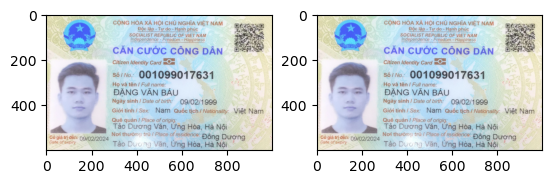

In [6]:
tl, tr, br, bl, warped1, orig = preprocess(path)
plt.subplot(1,2,1)
plt.imshow(warped1)

tl, tr, br, bl, warped2, orig = preprocess2(path)
plt.subplot(1,2,2)
plt.imshow(warped2)

In [4]:
def preprocess(img_path):

    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ratio = img.shape[0] / 500.0
    orig = img.copy()
    image = imutils.resize(img, height = 500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gau = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gau, 75, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break

    tl, tr, br, bl, warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    return tl, tr, br, bl, warped, orig
def preprocess2(img_path):

    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ratio = img.shape[0] / 500.0
    orig = img.copy()
    image = imutils.resize(img, height = 500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gau = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gau, 75, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break

    tl, tr, br, bl, warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    return tl, tr, br, bl, warped, orig

def plot(img):
        tl, tr, br, bl, warped, orig = preprocess(img)
        img_new = cv2.circle(orig, [int(t) for t in tl], 20, (0,255,0), -1)
        img_new = cv2.circle(orig, [int(t) for t in tr], 20, (0,255,0), -1)
        img_new = cv2.circle(orig, [int(t) for t in bl], 20, (0,255,0), -1)
        img_new = cv2.circle(orig, [int(t) for t in br], 20, (0,255,0), -1)

        return img_new

def information(warped):
    name_ = warped[323:374, 290:800]
    ID_ = warped[240:300, 400:760]
    date_ = warped[365:405, 560:760]
    sex_ = warped[390:460, 460:570]
    origin_ = warped[470:520, 290:900]
    residence1_ = warped[505:550, 685:900]
    residence2_ = warped[545:620, 290:900]
    return name_, ID_, date_, sex_, origin_, residence1_, residence2_

def resize(img):
    w, h = img.shape
    if (32/w < 416/h):
        scale_percent = 32/w
    else:
        scale_percent = 416/h
    height = int(img.shape[0] * scale_percent)
    width = int(img.shape[1] * scale_percent)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return img

def reshape_expand_dim(img):
    w, h = img.shape
    if w < 32:
            add_zeros = np.ones((32-w, h))*210
            img = np.concatenate((img, add_zeros))
    if h < 416:
        add_zeros = np.ones((32, 416-h))*210
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)

    return img

def read_data(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = resize(img)
    img = reshape_expand_dim(img)
    img = img/255.
    img = np.array(img)

    return img

In [5]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warped = cv2.resize(warped, (1000, 600))
    return tl, tr, br, bl, warped

In [10]:
p1 = (395, 240)
p2 = (1840, 640)
p3 = (1615, 1590)
p4 = (30, 1120)
a = cv2.circle(img.copy(), p1, 10, (255,0,0), -1)
a = cv2.circle(a.copy(), p2, 10, (255,0,0), -1)
a = cv2.circle(a.copy(), p3, 10, (255,0,0), -1)
a = cv2.circle(a.copy(), p4, 10, (255,0,0), -1)

plt.imshow(a)

NameError: name 'img' is not defined

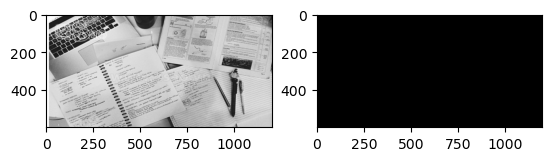

In [8]:
bg = cv2.imread(r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\codes\ban_hoc.jpg")
bg = cv2.resize(bg, (1200,600))
h, w, _ = bg.shape

black_bg = np.zeros((600, 1200, 3))
# print(black_bg.shape)

plt.subplot(1,2,1)
plt.imshow(bg)

plt.subplot(1,2,2)
plt.imshow(black_bg)

In [9]:
input_pts = np.float32([[395, 240],[1840, 640],[1615, 1590],[30, 1120]])

output_pts = np.float32([[0, 0],
                        [500, 0],
                        [500, 300],
                        [0, 300]])

M = cv2.getPerspectiveTransform(input_pts,output_pts)

out = cv2.warpPerspective(img,M,(500, 300),flags=cv2.INTER_LINEAR)


plt.subplot(1,2,1)
plt.imshow(out)

w_new = int(w*0.3)
h_new = int(300*(w_new/500))
print(w_new, h_new)

out_auto = cv2.resize(out, (w_new, h_new) )
h_, w_, _ = out_auto.shape
print(type(out_auto))

plt.subplot(1,2,2)
plt.imshow(out_auto)

NameError: name 'img' is not defined

In [ ]:
x_min = int(w*0.4)
y_min = int(h*0.4)
x_max = int(w*0.6)
y_max = int(h*0.6)
print(x_max, y_max)

In [ ]:
x1 = np.random.randint(x_min, x_max)
y1 = np.random.randint(y_min, y_max)

b = cv2.circle(black_bg.copy(), (x1,y1), 10, (255,0,0), -1)
b = cv2.circle(b.copy(), (x1+ w_, y1), 10, (255,0,0), -1)
b = cv2.circle(b.copy(), (x1+ w_, y1+h_), 10, (255,0,0), -1)
b = cv2.circle(b.copy(), (x1, y1+h_), 10, (255,0,0), -1)
plt.imshow(b)

In [ ]:
bg[y1:y1+h_ , x1:x1+w_] = out_auto
plt.subplot(1,2,1)
plt.imshow(bg)

black_bg[y1:y1+h_ , x1:x1+w_] = out_auto
plt.subplot(1,2,2)
plt.imshow(black_bg)

In [ ]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated


In [7]:
angle = 10
out_bg = rotate(bg, angle)
h,w,_ = out_bg.shape
plt.subplot(1,2,1)
plt.imshow(out_bg)


out_bg_black = rotate(black_bg, angle)
plt.subplot(1,2,2)
plt.imshow(out_bg_black)

NameError: name 'bg' is not defined

In [8]:
input_pts = np.float32([[0, 0],[w*0.95, 0],[w, h],[0, h*0.95]])

output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

M = cv2.getPerspectiveTransform(input_pts,output_pts)

out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
plt.subplot(1,2,1)
plt.imshow(out1)


out2 = cv2.warpPerspective(out_bg_black.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
plt.subplot(1,2,2)
plt.imshow(out2)

NameError: name 'w' is not defined

In [9]:
# import pandas as pd
# data = {'Name': ['John'], 'Age': [25], 'City': ['New York']}
# data = [['John', 25, 'New York']]
# df = pd.DataFrame(data)
# df.to_csv('output.csv', mode='a', header=False, index=False)


In [10]:
plt.imshow(out2)
print(out2.shape)

NameError: name 'out2' is not defined

In [11]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform2(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

#     widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
#     widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
#     maxWidth = max(int(widthA), int(widthB))

#     heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
#     heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
#     maxHeight = max(int(heightA), int(heightB))

#     dst = np.array([
#         [0, 0],
#         [maxWidth - 1, 0],
#         [maxWidth - 1, maxHeight - 1],
#         [0, maxHeight - 1]], dtype = "float32")

#     M = cv2.getPerspectiveTransform(rect, dst)
#     warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
#     warped = cv2.resize(warped, (1000, 600))
    return tl, tr, br, bl

def preprocess2(img):

#     img = cv2.imread(img_path)
#     h, w = img.shape[:2]
#     # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     ratio = img.shape[0] / 500.0
#     orig = img.copy()
#     image = imutils.resize(img, height = 500)
    img = img.astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.dilate(gray,kernel,iterations = 3)
    gau = cv2.GaussianBlur(erosion, (5, 5), 0)
    edged = cv2.Canny(gau, 150, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break

    tl, tr, br, bl = four_point_transform2(orig, screenCnt.reshape(4, 2))
    return tl, tr, br, bl, warped, orig

tl, tr, br, bl, warped1, orig = preprocess2(out2)
print(tl, tr, br, bl)

NameError: name 'out2' is not defined

In [12]:
tl = [int(num) for num in tl]
tr = [int(num) for num in tr]
bl = [int(num) for num in bl]
br = [int(num) for num in br]
print(tl, tr, br, bl)

NameError: name 'tl' is not defined

In [13]:
b = cv2.circle(out2.copy(), tl, 10, (255,0,0), -1)
b = cv2.circle(b.copy(), tr, 10, (255,0,0), -1)
b = cv2.circle(b.copy(), bl, 10, (255,0,0), -1)
b = cv2.circle(b.copy(), br, 10, (255,0,0), -1)

plt.imshow(b)

NameError: name 'out2' is not defined

In [14]:
abc = []
abc.append(tl)
abc.append(tr)
abc.append(br)
abc.append(bl)
abc

NameError: name 'tl' is not defined

In [15]:
import csv
path = "bau1.jpg"
points = [[530, 333], [897, 273], [915, 489], [551, 552]]
csv_filename = 'points.csv'

# Open the CSV file in write mode
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the flattened list of coordinates as a single row
    writer.writerow([path] +[coord for point in abc for coord in point])

PermissionError: [Errno 13] Permission denied: 'points.csv'

In [5]:
import cv2
import numpy as np
import pandas as pd

data = pd.read_csv('points1.csv', header = None)
y1 = data.iloc[:, 1:9].values
print(y1[-1,:])
print(len(y1))
data.head()


[0.304 0.415 0.608 0.365 0.64  0.562 0.336 0.611]
78237


,0,1,2,3,4,5,6,7,8,9
0,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.462,0.241,0.836,0.235,0.832,0.412,0.458,0.429,1
1,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.243,0.358,0.577,0.397,0.564,0.728,0.230,0.684,1
2,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.168,0.300,0.560,0.246,0.590,0.538,0.198,0.591,1
3,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.386,0.314,0.773,0.465,0.715,0.886,0.325,0.746,1
4,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.342,0.416,0.788,0.437,0.746,0.634,0.294,0.626,1


In [6]:


data = pd.read_csv('points2.csv', header = None)
y2 = data.iloc[:, 1:9].values

print(len(y2))
data.head()


37073


,0,1,2,3,4,5,6,7,8,9
0,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.088,0.124,0.822,0.114,0.830,0.492,0.094,0.500,1
1,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.111,0.132,0.806,0.115,0.812,0.779,0.118,0.794,1
2,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.119,0.093,0.858,0.140,0.833,0.693,0.096,0.641,1
3,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.132,0.144,0.836,0.142,0.836,0.938,0.133,0.938,1
4,C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/outp...,0.142,0.095,0.790,0.112,0.775,0.421,0.128,0.404,1


In [9]:
type(y2)

numpy.ndarray

In [10]:
y = np.concatenate((y1,y2))
len(y)

115310

In [11]:
y[0,: ]

array([0.462, 0.241, 0.836, 0.235, 0.832, 0.412, 0.458, 0.429])

In [12]:
y[78236,: ]

array([0.304, 0.415, 0.608, 0.365, 0.64 , 0.562, 0.336, 0.611])

In [13]:
y[78237,: ]

array([0.088, 0.124, 0.822, 0.114, 0.83 , 0.492, 0.094, 0.5  ])

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imutils
import glob
import random
import csv
from PIL import Image, ImageOps

def rotate(image, angle, center = None, scale = 1):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warped = cv2.resize(warped, (1000, 600))
    return tl, tr, br, bl, warped

def order_points2(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform2(image, pts):

    rect = order_points2(pts)
    (tl, tr, br, bl) = rect
    return tl, tr, br, bl

def preprocess2(img):
    img = img.astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.dilate(gray,kernel,iterations = 1)
    gau = cv2.GaussianBlur(erosion, (5, 5), 0)
    edged = cv2.Canny(gau, 3, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
#             print(type(screenCnt))
#             print(screenCnt)
            break
        else:
            screenCnt = np.array([[0,0], [0, 0], [0,0], [0, 0]])
            

    tl, tr, br, bl = four_point_transform2(img.copy(), screenCnt.reshape(4, 2))
    return tl, tr, br, bl, edged

def add_white_border(image, border_size):

    # Calculate the new dimensions
    height, width, _ = image.shape
    new_width = width + (2 * border_size)
    new_height = height + (2 * border_size)

    # Create a new white background image
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, 
                                                border_size, border_size, 
                                                cv2.BORDER_CONSTANT, value=(255, 255, 255))

    return bordered_image

def trans1(out_bg, out_black_bg):
#     flexible = np.random.uniform(0.98,1.02)
    input_pts = np.float32([[w*0.1, h*0.1],[w, 0],[w, h],[w*0.1, h]])
    output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    out2 = cv2.warpPerspective(out_black_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    
    return out1, out2

def trans2(out_bg, out_black_bg):
#     flexible = np.random.uniform(0.98,1.02)
    input_pts = np.float32([[0, 0],[w*0.9, h*0.1],[w*0.9, h],[0, h]])
    output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    out2 = cv2.warpPerspective(out_black_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    
    return out1, out2

def trans3(out_bg, out_black_bg):
#     flexible = np.random.uniform(0.98,1.02)
    input_pts = np.float32([[w*0.1, 0],[w, 0],[w, h],[w*0.1, h*0.9]])
    output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    out2 = cv2.warpPerspective(out_black_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    return out1, out2

    
def trans4(out_bg, out_black_bg):
#     flexible = np.random.uniform(0.98,1.02)
    input_pts = np.float32([[0, 0],[w*0.9, 0],[w*0.9, h*0.9],[0, h]])
    output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    out2 = cv2.warpPerspective(out_black_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
    return out1, out2

In [10]:
path_bg = "/home/lam/bau/CCCD/detect4point/dataset/bg/*"
path_img = "/home/lam/bau/CCCD/detect4point/dataset/crop_ID_card_real/*"
a = 0

#     print(h, w)\
for image in glob.glob(path_img):
    
    for file in glob.glob(path_bg):
        print(file)
        flipp = [-1, 0, 1]
        fl = random.choice(flipp)
        bg = cv2.imread(file)
        bg = cv2.flip(bg, fl)
        h, w, _ = bg.shape
        black_bg = np.zeros((h, w, 3))

        img = cv2.imread(image)
        h_, w_, _ = img.shape
#        add border
        border_size = 10
        img_border = add_white_border(img, border_size)

        #resize card
        w_new = int(w*0.35)
        h_new = int(h_*(w_new/w_))

        out_auto = cv2.resize(img, (w_new, h_new) )
        out_auto2 = cv2.resize(img_border, (w_new, h_new) )
        h_, w_, _ = out_auto.shape


        x_min = int(w*0.2)
        y_min = int(h*0.2)
        x_max = int(w*0.25)
        y_max = int(h*0.25)

        x1 = np.random.randint(x_min, x_max)
        y1 = np.random.randint(y_min, y_max)


        #add card in bg
        if  (y1+h_) < h:
            bg[y1:y1+h_ , x1:x1+w_] = out_auto
            black_bg[y1:y1+h_ , x1:x1+w_] = out_auto2
        
        else:
            continue

        # rotate img
        angle = np.random.randint(-3,3)
        out_bg = rotate(bg, angle)
        h,w,_ = out_bg.shape
        out_black_bg = rotate(black_bg, angle)

        # Tranform img (làm méo hình)
        if a < 2500:
            out1, out2 = trans1(out_bg, out_black_bg)
            h, w, _ = out1.shape

            tl, tr, br, bl, canny = preprocess2(out2)
            min_x = min(tl[0], bl[0])
            max_x = max(tr[0], br[0])

            ab = np.random.uniform(0.6, 0.9)
            bc = np.random.uniform(0.1, 0.4)
            out_new1 = out1[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]
            out_new2 = out2[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]

            fi = str(a)
            path_save1 = "/home/lam/bau/CCCD/detect4point/yolo/dataset1/images/train/" + fi + "_1.jpg"
            file_path = '/home/lam/bau/CCCD/detect4point/yolo/dataset1/labels/train/' + fi + '_1.txt'
            cv2.imwrite(path_save1, out_new1)
            
        elif a >= 2500 and a < 5000:
            out1, out2 = trans2(out_bg, out_black_bg)
            h, w, _ = out1.shape

            tl, tr, br, bl, canny = preprocess2(out2)
            min_x = min(tl[0], bl[0])
            max_x = max(tr[0], br[0])

            ab = np.random.uniform(0.6, 0.9)
            bc = np.random.uniform(0.1, 0.4)
            out_new1 = out1[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]
            out_new2 = out2[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]

            fi = str(a)
            path_save1 = "/home/lam/bau/CCCD/detect4point/yolo/dataset1/images/train/" + fi + "_2.jpg"
            file_path = '/home/lam/bau/CCCD/detect4point/yolo/dataset1/labels/train/' + fi + '_2.txt'
            cv2.imwrite(path_save1, out_new1)
            
        elif a >= 5000 and a < 7500:
            out1, out2 = trans3(out_bg, out_black_bg)
            h, w, _ = out1.shape

            tl, tr, br, bl, canny = preprocess2(out2)
            min_x = min(tl[0], bl[0])
            max_x = max(tr[0], br[0])

            ab = np.random.uniform(0.6, 0.9)
            bc = np.random.uniform(0.1, 0.4)
            out_new1 = out1[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]
            out_new2 = out2[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]

            fi = str(a)
            path_save1 = "/home/lam/bau/CCCD/detect4point/yolo/dataset1/images/train/" + fi + "_3.jpg"
            file_path = '/home/lam/bau/CCCD/detect4point/yolo/dataset1/labels/train/' + fi + '_3.txt'
            cv2.imwrite(path_save1, out_new1)
            
        elif a >= 7500 and a < 1000:
            out1, out2 = trans3(out_bg, out_black_bg)
            h, w, _ = out1.shape

            tl, tr, br, bl, canny = preprocess2(out2)
            min_x = min(tl[0], bl[0])
            max_x = max(tr[0], br[0])

            ab = np.random.uniform(0.6, 0.9)
            bc = np.random.uniform(0.1, 0.4)
            out_new1 = out1[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]
            out_new2 = out2[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]

            fi = str(a)
            path_save1 = "/home/lam/bau/CCCD/detect4point/yolo/dataset1/images/train/" + fi + "_4.jpg"
            file_path = '/home/lam/bau/CCCD/detect4point/yolo/dataset1/labels/train/' + fi + '_4.txt'
            cv2.imwrite(path_save1, out_new1)
            
        else:
            out1, out2 = trans4(out_bg, out_black_bg)
            h, w, _ = out1.shape

            tl, tr, br, bl, canny = preprocess2(out2)
            min_x = min(tl[0], bl[0])
            max_x = max(tr[0], br[0])

            ab = np.random.uniform(0.6, 0.9)
            bc = np.random.uniform(0.1, 0.4)
            out_new1 = out1[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]
            out_new2 = out2[0:h , int(min_x * ab): int(max_x + (w- max_x)* bc)]

            fi = str(a)
            path_save1 = "/home/lam/bau/CCCD/detect4point/yolo/dataset1/images/val/" + fi + ".jpg"
            file_path = '/home/lam/bau/CCCD/detect4point/yolo/dataset1/labels/val/' + fi + '.txt'
            cv2.imwrite(path_save1, out_new1)
        
        h, w, _ = out_new2.shape
        tl, tr, br, bl, canny = preprocess2(out_new2)
        with open(file_path, 'w') as file:
            # Append some text to the file
            file.write("0 "+ str(tl[0]/w) +" " + str(tl[1]/h) +" "+str(0.05)+" "+ str(0.05) +"\n")
            file.write("1 "+ str(tr[0]/w) +" " + str(tr[1]/h) +" "+str(0.05)+" " +str(0.05) +"\n")
            file.write("2 "+ str(br[0]/w) +" " + str(br[1]/h) +" "+str(0.05)+" " +str(0.05) +"\n")
            file.write("3 "+ str(bl[0]/w) +" " + str(bl[1]/h) +" "+str(0.05)+" " +str(0.05))
        a+=1
        print(a)
        if a == 12000:
            break
    if a == 12000: break   
        
#         tl, tr, br, bl, canny = preprocess2(out_new2)
# #         path_save2 = "C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/output2/" + fi + "_canny.jpg"
# #         cv2.imwrite(path_save2, canny)
#         tl = tl / np.array([w, h])
#         tr = tr / np.array([w, h])
#         bl = bl / np.array([w, h])
#         br = br / np.array([w, h])

#         tl = [round(num, 3) for num in tl]
#         tr = [round(num, 3) for num in tr]
#         bl = [round(num, 3) for num in bl]
#         br = [round(num, 3) for num in br]
#         abc = []
#         abc.append(tl)
#         abc.append(tr)
#         abc.append(br)
#         abc.append(bl)



#         csv_filename = 'pointss.csv'

#         # Open the CSV file in write mode
#         with open(csv_filename, 'a+', newline='') as csvfile:
#             writer = csv.writer(csvfile)

#             # Write the flattened list of coordinates as a single row
#             writer.writerow([path_save1] + [coord for point in abc for coord in point]+ [1])

#         a+=1
#         if a == 12000:
#             break
#     if a == 12000: break

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\bg1\a (1).jpeg
C:\Users\ADMIN\Des

KeyboardInterrupt: 

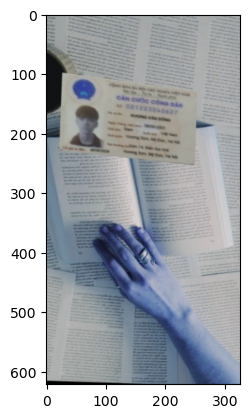

In [11]:
import cv2
'''0 0.07668711656441718 0.15594855305466238 0.05 0.05
1 0.7852760736196319 0.2057877813504823 0.05 0.05
2 0.7699386503067485 0.409967845659164 0.05 0.05
3 0.06441717791411043 0.37138263665594856 0.05 0.05'''

points = [0.076,0.156,
          0.785,0.205,
          0.7699,0.4099,
          0.064,0.371
]

path = "C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/card/test/0_1.jpg"
img = cv2.imread(path)
h, w, _ = img.shape
plt.imshow(img)

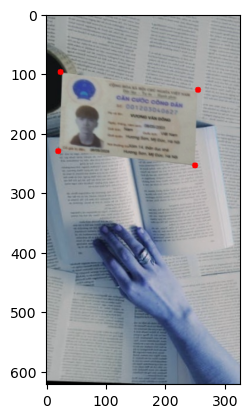

In [12]:
b = cv2.circle(img.copy(), (int(points[0]*w),int(points[1]*h)) , 5, (255,0,0), -1)
b = cv2.circle(b.copy(), (int(points[2]*w),int(points[3]*h)) , 5, (255,0,0), -1)
b = cv2.circle(b.copy(), (int(points[4]*w),int(points[5]*h)) , 5, (255,0,0), -1)
b = cv2.circle(b.copy(), (int(points[6]*w),int(points[7]*h)) , 5, (255,0,0), -1)
plt.imshow(b)

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

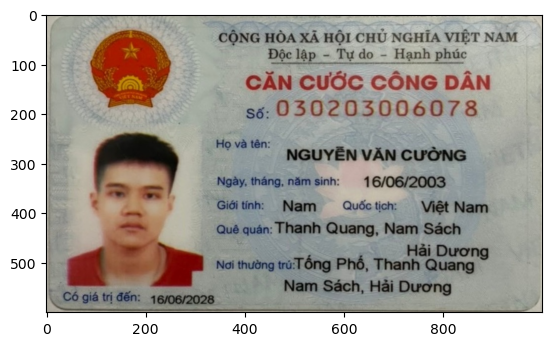

In [2]:
img = cv2.imread(r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\web_app\static\c\cccd_truoc1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1000, 600))
plt.imshow(img)

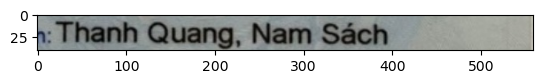

In [4]:
ori = img[410:450, 440:1000]
plt.imshow(ori)

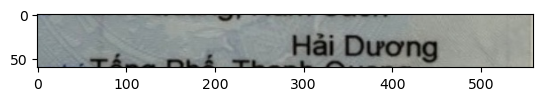

In [7]:
ori2 = img[440:500, 440:1000]
plt.imshow(ori2)

In [21]:
def check_number(string):
    for i in string:
        if i.isdigit():
            return True
    return False
name1 = '4765'

if check_number(name1):
    print('hrge')
# name

hrge
